In [1]:
from IPython.display import HTML
from base64 import b64encode

In [2]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow 
import keras
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
import json
from base64 import b64encode
from IPython.display import HTML, display
from tensorflow.keras.models import load_model


In [3]:
from sklearn.model_selection import train_test_split
 
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
def play_video(filepath):
    with open(filepath, 'rb') as video_file:
        video_data = video_file.read()
    video_src = f"data:video/mp4;base64,{b64encode(video_data).decode()}"
    html_content = f'<video width=640 controls autoplay loop><source src="{video_src}" type="video/mp4"></video>'
    display(HTML(html_content))


In [5]:
play_video(r"C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\NonViolence\NV_9.mp4")

In [6]:
play_video(r"C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\Violence\V_112.mp4")

In [7]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
SEQUENCE_LENGTH = 16


DATASET_DIR = r"C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset"
 
CLASSES_LIST = ["NonViolence","Violence"]

In [8]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)

    if not video_reader.isOpened():
        print(f"Warning: Could not open video {video_path}")
        return frames_list 

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        
        success, frame = video_reader.read()
        
        if not success or frame is None:
            print(f"Warning: Error reading frame {frame_counter} in video {video_path}")
            continue 
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

In [9]:
from tqdm import tqdm

def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in tqdm(files_list, desc=f"Processing {class_name}", leave=False):
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            
            frames = frames_extraction(video_file_path)
            
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels, video_files_paths


In [10]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence


Extracting Data of Class: Violence


In [11]:
np.save("features.npy",features)
np.save("labels.npy",labels)
np.save("video_files_paths.npy",video_files_paths)

In [12]:
import zipfile

file_paths = [
    r'C:\Users\HP\Downloads\real life violence situations\video_files_paths.npy',
    r'C:\Users\HP\Downloads\real life violence situations\features.npy',
    r'C:\Users\HP\Downloads\real life violence situations\labels.npy'
]

zip_file_path = r'C:\Users\HP\Downloads\real life violence situations\archive.zip'

with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for file in file_paths:
        zipf.write(file, arcname=file.split('/')[-1])  # arcname để lưu tên tệp gốc trong zip

print(f"Files have been compressed into {zip_file_path}")

Files have been compressed into C:\Users\HP\Downloads\real life violence situations\archive.zip


In [13]:
one_hot_encoded_labels = to_categorical(labels)

In [14]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                            shuffle = True, random_state = 42)

In [15]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)


In [16]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

C:\Users\HP\AppData\Local\Temp\ipykernel_4444\820632974.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2( include_top=False , weights="imagenet")


In [17]:
mobilenet.trainable = True

In [18]:
for layer in mobilenet.layers[:-40]:
  layer.trainable=False

In [19]:
mobilenet.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,681,536 (6.41 MB)

 Non-trainable params: 576,448 (2.20 MB)

In [20]:
def create_model():
    
    model = Sequential()
    
    model.add(Input(shape = (16, 64, 64, 3)))
    
    model.add(TimeDistributed(mobilenet))
    
    model.add(Dropout(0.25))
                                    
    model.add(TimeDistributed(Flatten()))

    
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)  

    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))
    
    model.add(Dropout(0.25))

    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
  
    model.summary()
    return model

In [21]:
mobinet_lstm_model = create_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 2, 2, 1280) │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 2, 2, 1280) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 5120)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │     1,319,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,637,090 (13.87 MB)

 Trainable params: 3,060,642 (11.68 MB)

 Non-trainable params: 576,448 (2.20 MB)

In [22]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 40, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

In [23]:
mobinet_lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

In [24]:
with tf.device('/GPU:0'):
    history = mobinet_lstm_model.fit(
        x=features_train, 
        y=labels_train, 
        epochs=50, 
        batch_size=8, 
        shuffle=True, 
        validation_split=0.2, 
        callbacks=[early_stopping_callback, reduce_lr]
    )

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.5081 - loss: 0.6956 - val_accuracy: 0.5778 - val_loss: 0.6885 - learning_rate: 0.0100
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5372 - loss: 0.6908 - val_accuracy: 0.6472 - val_loss: 0.6842 - learning_rate: 0.0100
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 173s 960ms/step - accuracy: 0.5317 - loss: 0.6897 - val_accuracy: 0.6889 - val_loss: 0.6618 - learning_rate: 0.0100
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 151s 837ms/step - accuracy: 0.5908 - loss: 0.6685 - val_accuracy: 0.7722 - val_loss: 0.5602 - learning_rate: 0.0100
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 157s 874ms/step - accuracy: 0.7385 - loss: 0.5695 - val_accuracy: 0.8222 - val_loss: 0.4457 - learning_rate: 0.0100
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 171s 950ms/step - accuracy: 0.8094 - loss: 0.4628 - val_accuracy: 0.8278 - val_loss: 0.4224 - learning_rate: 0.0100
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 175s 974ms/step - accuracy: 0.

In [25]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
 
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)
 
    plt.title(str(plot_name))
 
    plt.legend()

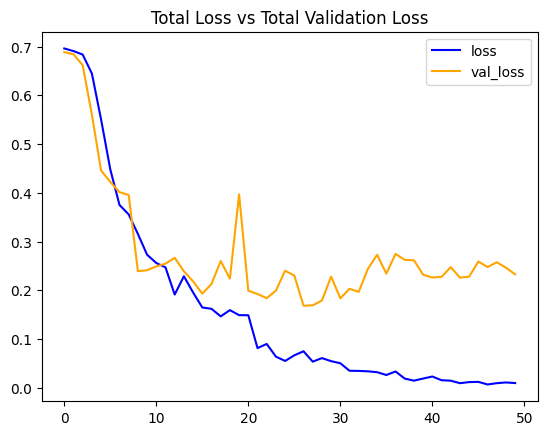

In [26]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

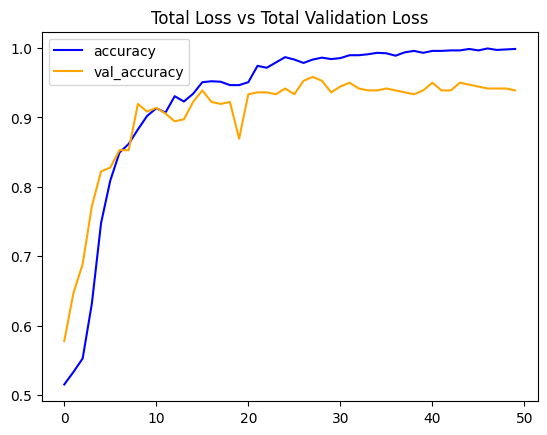

In [27]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [28]:
labels_predict = mobinet_lstm_model.predict(features_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step


In [29]:
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)
labels_test_normal.shape , labels_predict.shape

((200,), (200,))

In [30]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', accuracy)

Accuracy Score is :  0.94


In [31]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
 
    video_reader = cv2.VideoCapture(video_file_path)

 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    frames_list = []
    
    predicted_class_name = ''
 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
 
    for frame_counter in range(SEQUENCE_LENGTH):
 
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 
 
        if not success:
           break
 
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)   
 
    predicted_labels_probabilities = mobinet_lstm_model.predict(np.expand_dims(frames_list, axis = 0))[0]
 
    predicted_label = np.argmax(predicted_labels_probabilities)
 
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [48]:
video_path = r"C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\NonViolence\NV_548.mp4"
predict_video(video_path, SEQUENCE_LENGTH)

play_video(video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted: NonViolence
Confidence: 0.9987590312957764


In [49]:
# Save the model in the new Keras format
mobinet_lstm_model.save(r'C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\mobinet_lstm_model.keras')
print(r"Model has been saved in the new Keras format as C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\mobinet_lstm_model.keras")


Model has been saved in the new Keras format as C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\mobinet_lstm_model.keras


In [34]:
from tensorflow.keras.models import load_model
mobinet_lstm_model = load_model(r'C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\mobinet_lstm_model.keras')

In [35]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)
 
    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
 
    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
 
    # Store the predicted class in the video.
    predicted_class_name = ''
 
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():
 
        ok, frame = video_reader.read() 
        
        if not ok:
            break
 
        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame 
        normalized_frame = resized_frame / 255
 
        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)
 
        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:                        
 
            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = mobinet_lstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
 
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)
 
            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]
 
        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)
         
        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)                       
        
    video_reader.release()
    video_writer.release()

In [ ]:
# Assuming 'history' is the variable returned by model.fit()
with open('training_history1.json', 'w') as f:
    json.dump(history.history, f)


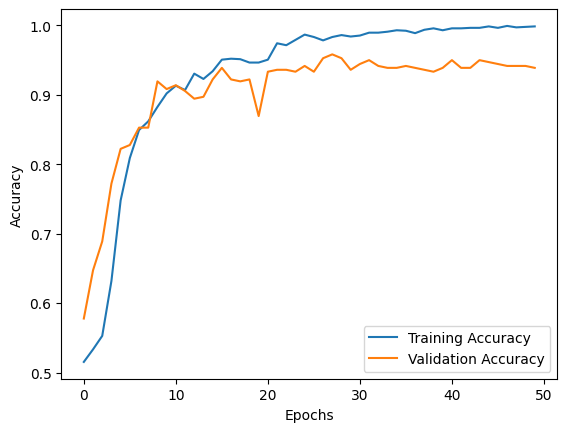

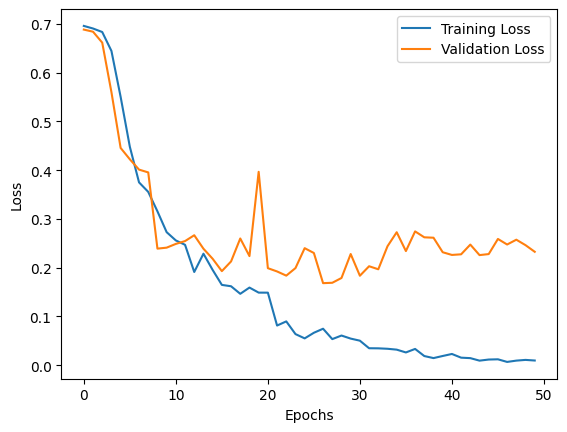

In [44]:
with open('training_history.json', 'r') as f:
    history = json.load(f)

# Plot training & validation accuracy
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [45]:
input_path = r"C:\Users\HP\Downloads\real life violence situations\Real Life Violence Dataset\NonViolence\NV_139.mp4"
output_path = r"C:\Users\HP\Downloads\videos\NV_139_result.mp4"
predict_frames(input_path, output_path, SEQUENCE_LENGTH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━